In [1]:
%matplotlib inline
import matplotlib as mpl
import networkx as nx
import numpy as np
from random import randint
from IPython.display import Image, HTML

In [2]:
# Disable plot axes by default
if True:
    mpl.rc('axes.spines', top=False, bottom=False, left=False, right=False)
    mpl.rc('xtick', top=False, bottom=False, labelsize=0)
    mpl.rc('ytick', left=False, right=False, labelsize=0)

## Eulerian circuit algorithm

In [6]:
def slow_eulerian_circuit(nv, edges, directed=False, debug=False):
    adj = [[] for i in range(nv)]
    for a,b in edges:
        adj[a].append(b)
        if not directed:
            adj[b].append(a)
    for v in range(nv):
        adj[v].sort()

    if any(len(a) % 2 for a in adj):
        return None  # not eulerian

    if debug:
        print(': adj=%s' % {n:v for n,v in enumerate(adj)})
    
    c_all = []
    while True:
        for s in (c_all or range(nv)):
            if adj[s]:
                break
        else:
            break

        if debug:  print('-- %s -- %s' % ([s], {n:d for n,d in enumerate(adj)}))

        c_cur = [s]
        v = s
        while adj[v]:
            w = adj[v][0]
            adj[v].remove(w)
            if not directed:
                adj[w].remove(v)
            c_cur.append(w)
            v = w
            #if debug:  print('-- %s -- %s' % (c_cur, {n:d for n,d in enumerate(adj)}))

        if debug:  print('-- %s -- %s' % (c_cur, {n:d for n,d in enumerate(adj)}))
        assert c_cur[0] == c_cur[-1]

        if debug:
            print('< c_all %s' % (c_all,))
        if c_all:
            i = c_all.index(s)
            c_all[i:i+1] = c_cur
        else:
            c_all.extend(c_cur)
            i = -1

        if debug:
            print('> i=%d %s' % (i, c_all))

    assert c_all[0] == c_all[-1]
    c_all = c_all[:-1]
    if debug:
        print('= %s' % c_all)
    return c_all

In [108]:
def fast_eulerian_circuit(nv, edges):
    adj = [[] for i in range(nv)]
    for a,b in edges:
        adj[a].append(b)
        adj[b].append(a)
    for v in range(nv):
        adj[v].sort()

    if any(not(a) or len(a) % 2 == 1 for a in adj):
        return None  # not connected or not eulerian

    ca = []
    while True:
        for s in (ca or range(nv)):
            if adj[s]:
                break
        else:
            break

        cc = [s]
        v = s
        while adj[v]:
            w = adj[v][0]
            adj[v].remove(w)
            adj[w].remove(v)
            cc.append(w)
            v = w

        assert cc[0] == cc[-1]
        if ca:
            i = ca.index(s)
            ca[i:i+1] = cc
        else:
            ca.extend(cc)

    if any(a for a in adj):
        return None

    assert ca[0] == ca[-1]
    return ca[:-1]

### Tests

In [102]:
def nx_eulerian_circuit(nv, edges, directed=False):
    g = nx.MultiDiGraph() if directed else nx.MultiGraph()
    g.add_nodes_from(range(nv))
    g.add_edges_from(edges)
    try:
        circuit = list(nx.eulerian_circuit(g))
        return [b for a,b in reversed(circuit)]
    except nx.NetworkXError:
        return None

def parse_stdin(stdin):
    rows = [list(map(int, line.split())) for line in stdin.splitlines()]
    nv, ne = rows[0]
    edges = [(a-1,b-1) for a,b in rows[1:]]
    return nv, edges

In [103]:
def is_eulerian_circuit_of(chain, nv, edges, debug=False):
    cycle = chain + [chain[0]]
    edges = [(min(a,b), max(a,b)) for a,b in edges]
    for i in range(len(chain)):
        a,b = cycle[i], cycle[i+1]
        e = (min(a,b), max(a,b))
        if debug:
            print('~ %s --%s-- %s' % (e, e in edges, edges))
        if e not in edges:
            return False
        edges.remove(e)
    if debug and edges:
        print('! %s' % edges)
    return not edges

In [104]:
def test_eulerian_circuit(stdin, stdout=None):
    nv, edges = parse_stdin(stdin)
    my_ret = fast_eulerian_circuit(nv, edges)
    nx_ret = nx_eulerian_circuit(nv, edges)
    if my_ret is None:
        print('** NONE')
    else:
        print('** %s' % ' '.join(str(v+1) for v in my_ret))
    if nx_ret is None:
        assert my_ret is None
    else:
        assert is_eulerian_circuit_of(my_ret, nv, edges)
    if stdout is not None:
        if stdout == 'NONE':
            ok_ret = None
        else:
            ok_ret = [v-1 for v in map(int, stdout.split())]
        assert my_ret == ok_ret
    return my_ret

In [105]:
test_eulerian_circuit('4 2\n1 2\n3 2\n', 'NONE')
test_eulerian_circuit('3 3\n1 2\n2 3\n3 1\n', '1 2 3')
test_eulerian_circuit('8 14\n1 2\n2 3\n3 2\n3 1\n2 4\n4 3\n4 5\n5 7\n7 5\n7 6\n6 4\n5 8\n8 8\n8 7\n',
                      '1 2 3 4 5 7 5 8 8 7 6 4 2 3')
test_eulerian_circuit('8 14\n8 7\n7 6\n8 6\n6 8\n8 1\n6 1\n1 5\n5 4\n4 4\n4 3\n5 3\n3 5\n3 2\n2 1\n',
                      '1 2 3 5 3 4 4 5 1 6 8 6 7 8')
test_eulerian_circuit('7 8\n4 1\n1 2\n2 3\n3 4\n4 5\n5 6\n6 7\n7 4\n', '1 2 3 4 5 6 7 4')
test_eulerian_circuit('8 9\n4 1\n1 2\n2 3\n3 4\n4 5\n5 6\n6 7\n7 4\n8 8\n', 'NONE')
test_eulerian_circuit('9 8\n4 1\n1 2\n2 3\n3 4\n4 5\n5 6\n6 7\n7 4\n', 'NONE')
print('OK')

** NONE
** 1 2 3
** 1 2 3 4 5 7 5 8 8 7 6 4 2 3
** 1 2 3 5 3 4 4 5 1 6 8 6 7 8
** 1 2 3 4 5 6 7 4
** NONE
** NONE
OK


In [106]:
def make_random_eulerian(max_nodes, min_nodes=4, max_edges=4, max_multi=4, can_loop=False, directed=False):
    max_nodes = max(max_nodes, min_nodes)
    while True:
        num = randint(min_nodes, max_nodes)
        deg = [randint(1, max_edges) for i in range(num)]
        G = nx.directed_configuration_model(in_degree_sequence=deg,
                                            out_degree_sequence=deg)
        nv = len(G.nodes)
        edges = []
        for a,b,c in list(G.edges):
            e = (min(a,b), max(a,b))
            if edges.count(e) >= max_multi:
                continue
            if not can_loop and e[0] == e[1]:
                continue
            edges.append(e)
        edges = sorted(edges)
        M = nx.MultiGraph(edges)
        if len(M) and nx.is_connected(M) and nx.is_eulerian(M):
            C = nx_eulerian_circuit(nv, edges)
            if C is not None:
                return nv, edges, M

In [107]:
#%%timeit -r1 -n1

num_test = 200
for _ in range(num_test):
    nv, edges, G = make_random_eulerian(max_nodes=50, max_multi=4, can_loop=True)
    T = fast_eulerian_circuit(nv, edges)
    assert T is not None
    assert is_eulerian_circuit_of(T, nv, edges)

print('OK')

OK


In [66]:
# debug cell: run this one if something goes wrong
print('+ E:', edges)
C = nx_eulerian_circuit(nv, edges)
T = fast_eulerian_circuit(nv, edges)
print('+ C:', C)
print('+ T:', T)
print(is_eulerian_circuit_of(T, nv, edges))
HTML(nx.drawing.nx_pydot.to_pydot(G).create_svg(prog='neato').decode())

+ E: [(0, 2), (0, 4), (1, 6), (1, 7), (2, 4), (2, 4), (2, 7), (3, 7), (3, 7), (4, 4), (4, 5), (4, 5), (4, 6), (6, 7), (6, 7), (7, 7)]
+ C: [0, 2, 4, 2, 7, 1, 6, 7, 3, 7, 7, 6, 4, 4, 5, 4]
+ T: [0, 2, 4, 4, 5, 4, 6, 7, 7, 3, 7, 6, 1, 7, 2, 4]
True


In [76]:
_stdin = '7 8\n4 1\n1 2\n2 3\n3 4\n4 5\n5 6\n6 7\n7 4\n'
_rows = [tuple(map(int, s.split())) for s in _stdin.strip().splitlines()]
G = nx.from_edgelist(_rows[1:])
HTML(nx.drawing.nx_pydot.to_pydot(G).create_svg(prog='neato').decode())

## Proof of the Eulerian circuit theorem

See [stepik video](https://stepik.org/lesson/10765/step/6?unit=10933) of the full proof.

![figure for proof](euler-graphs/euler-proof.svg)

# Homework

## Finding Eulerian paths

Пусть в связном графе $G$ ровно $2k$ вершин имеют нечетную степень. Доказать, что в этом графе можно построить $k$ таких путей, что каждое ребро графа $G$ будет принадлежать только одному из этих путей.

### Solution

**Шаг 1.**
В исходном $2k$ вершин имеют нечётную степень, а остальные (если есть) - чётную.

На иллюстрации к доказательству чётные вершины ($ABCD$) раскрашены синим,
а нечётные ($PQRSTU$)- жёлтым.
Число вершин и рёбер на рисунке приведено лишь для иллюстрации.
Главное, чтобы число жёлтых было чётным.

**Шаг 2.**
Временно добавим в граф новую вершину и проведём к ней по одному ребру от каждый нечётной вершины.

В дополненном графе:
 - все ранее чётные (синие) вершины останутся чётными;
 - все ранее нечётные (жёлтые) вершины получат по одному новому ребру и станут чётными;
 - временная (красная) вершина будет иметь $2k$ рёбер и тоже будет чётной.

На рисунке временная вершина $X$ и временные рёбра раскрашены красным. Исходные рёбра графа - зелёным.

**Шаг 3.**
Поскольку в дополненном графе все вершины чётные, то по теореме, которую преподаватель доказал на занятиях, в дополненном графе можно посторить _цикл Эйлера_, который:
 - пройдёт все вершины (некоторые по нескольку раз);
 - пройдёт по каждому ребру дополненного графа ровно один раз.
Возьмём этот цикл, и проходя по нему, будем присваивать вершинам порядковые номера $1,2,3,...$

Некоторые вершины при этом попадут в цикл несколько раз и получат несколько номеров.
Если некоторая вершина имеет в дополненном графе степень $D$ (чётную) то в цепи Эйлера в неё будут входить $D/2$ рёбер и выходить тоже $D/2$, а значит эта вершина попадётся в цепи Эйлера $D/2$ раз.

Временная вершина $X$ появится в цепи $k$ раз, так как ей инцидентны $2k$ рёбер из $2k$ жёлтых вершин.

**Шаг 4.**

Сделаем отображение дополненного графа на цепь Эйлера. Каждой вершине поставим в соответствие столько элементов цепи Эйлера, сколько раз эта вершина появилась в цепи. Важно, что в силу свойств цепи Эйлера каждому ребру из цепи взаимно однозначно соответствует ровно одно ребро из дополненного графа, то есть рёбра цепи полностью покрываюь дополненные граф. Но есть и разница: поскольку цепь упорядочена, рёбра в ней направленные, хотя в исходном графе - нет.

Если взять граф из иллюстрации в качестве примера, то вершине $A$ из дополненного графа будут соответствовать элементы $1A$ и $6A$, а вершине $X$ - элементы $4X$, $8X$, $16X$. 

**Шаг 5.**

По построению, каждая инкарнация временной красной вершины в цепи имеет только одно входящее ребро и одно выходящее, причём красная вершина соединяется только с жёлтыми. Таким образом, в цепи имеется $k$ (по числу вхождений красной вершины) сегментов вида: $(одно красное ребро, i-е вхождение красной вершины, второе красное ребро)$. Эти сегменты полностью состоят из элементов, которые не входили в исходный граф, а были добавлены временно.

Между "временными" (красными) сегментами будут находится сегменты, состоящие только из вершин и рёбер исходного графа. Все они непусты, так как содержат, как минимум по одной жёлтой вершине. Все они начинаются и кончаются на жёлтых вершинах.

Теперь удалим красные рёбра и вхождения красной вершины из цикла. Останутся только "исходные сегменты". Их количество равно $k$ (если из окружности вырезать $k$ кусков, то количество оставшихся тоже равно $k$, а цикл геометрически соответствует окружности). Поскольку из цепи удалялись только красные рёбра, оставшиеся рёбра полностью покрывают исходный граф из шага 1.

**Шаг 6.**
Обратим отображение. Каждому ребру из $k$ "исходных сегментов" взаимно однозначно соответствует ребро исходного графа. А значит, каждому сегменту соответсвует путь в исходном графе. Все вместе они полностью покрывают исходный граф из шага 1. Таких путей будет $k$. Цель достигнута.

Примечания:
  1. Я долго думал, как использовать цикл Эйлера в доказательстве. Идею добавить лишнюю вершину я
     подглядел в комментариях к задаче. Остальное додумал сам.
  2. Графы я генерировал в Питоне и подправлял в редакторе yEd.

![homework #1](euler-graphs/euler-k-path.svg)

## Red-blue coloring

Рассмотрим связный простой регулярный граф $G$, степень любой вершины которого равна четырем. Доказать, что ребра этого графа всегда можно покрасить в два цвета (красный и синий) так, чтобы любая вершина была инцидентна ровно двум синим и ровно двум красным ребрам.

### Solution

Поскольку все вершины графа чётные, мы можем построить для него Эйлеров цикл. Рёбра в цикле взаимно однозначно соответствуют рёбрам в исходном графе. Каждая вершина исходного графа появится в цикле ровно два раза (степень четыре = два раза вошли в вершину + два раза вышли). Количество рёбер в цикле чётное, а значит мы можем раскрасить их, чередуя два цвета (как на окружности). Как у первого вхождения вершины в цикл будут два разноцветных ребра (красное + синее), так и у второго. А в силу сохранения инцидентности между графом и циклом Эйлера мы получим, что хотели.

![red and blue](euler-graphs/euler-4-red-blue.svg)

## Minimum number of wire pieces to make a 1x1x1 cube

Имеется кусок проволоки длиной 12 сантиметров. На какое минимальное количество кусков его следует разрезать, чтобы из этих кусков можно было бы изготовить каркас кубика размерами 1 × 1 × 1 при условии, что проволоку в процессе изготовления кубиков можно сгибать?

### Solution

![cube pieces](euler-graphs/euler-cube-1x1x1.svg)

## Experiments...

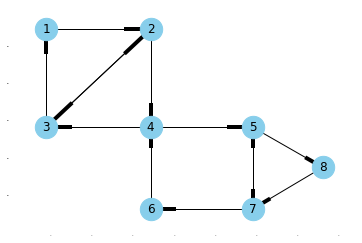

In [121]:
# read graphml from yEd
G = nx.read_graphml('euler-example-1.graphml')
G = nx.relabel_nodes(G, {n: int(d['label']) for n,d in G.node.data()})

# Fix a bug with self-loops
G.remove_edges_from([(3,3), (8,8)])

# Read layout from graphml
pos = {n: np.array([float(d['x']), -float(d['y'])]) for n,d in G.node.data()}
nx.draw_networkx(G, pos=pos, node_size=500, node_color='skyblue')

In [122]:
HTML(nx.drawing.nx_pydot.to_pydot(G).create_svg(prog='fdp').decode())

In [123]:
G.edges

OutMultiEdgeView([(1, 2, 'e1'), (2, 4, 'e2'), (2, 3, 'e12'), (3, 1, 'e4'), (3, 2, 'e11'), (4, 3, 'e3'), (4, 5, 'e5'), (5, 7, 'e6'), (5, 8, 'e9'), (6, 4, 'e8'), (7, 6, 'e7'), (7, 5, 'e13'), (8, 7, 'e10'), (8, 8, 'e14')])

### ....

In [92]:
# create a cycle graph
size = 2
G = nx.cycle_graph(size, create_using=nx.MultiDiGraph())

# make node labels start from `1'
G = nx.relabel_nodes(G, {i:i+1 for i in G.nodes})

# add reverse edges
if len(G.nodes) > 2:
    G.add_edges_from([(b,a) for a,b,_ in list(G.edges)])

# draw graph using graphviz
dot = nx.drawing.nx_pydot.to_pydot(G)
HTML(dot.create_svg(prog='neato').decode())